#  Y = 1 vs all

In [ ]:
#! git clone https://github.com/LeonardoDiCaterina/Machine_Learning_G19.git
#! mv Machine_Learning_G19/* .
#! pip install scikit-learn==1.5.1
#! pip install 
#!pip install joblib==1.2.0
#! pip install catboost
#! pip install xgboost
#! pip install lightgbm

In [ ]:
# sys.path.append('/content/Machine_Learning_G19/Library')
# train_path = "/content/Machine_Learning_G19/Data/train_data_mok.csv"
# test_path = "/content/Machine_Learning_G19/Data/test_data_mok.csv"

# checkpoint 1

In [1]:
YEQUALS = 1

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
import warnings
warnings.filterwarnings("ignore")
# install libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import os
! pwd
import sys
sys.path.append('../Library')

from data_prep import PreProcessor1

import library_leo as leo



/Users/leonardodicaterina/Documents/GitHub/Machine_Learning_G19/Notebooks


In [3]:
train_path = "../Data/train_data.csv"
test_path = "../Data/test_data.csv"
# Replace 'Column29' with the actual column name that has mixed types
dtype = {'Column29': 'str'}

train = pd.read_csv(train_path, dtype=dtype,index_col='Claim Identifier')
dtest = pd.read_csv(test_path, dtype=dtype,index_col='Claim Identifier')

In [4]:
train = train.dropna(subset=['Claim Injury Type'])
y = train['Claim Injury Type']
train = train.drop(columns=['Claim Injury Type'])
y_str = y.str[:1]
y_int = y_str.astype(int)
# make Y_int 1 if it's equal to YEQUALS else 0
y_int = y_int.apply(lambda x: 1 if x == YEQUALS else 0)

In [5]:
# partition the data X, y and y_2bin
X_train, X_valid, y_train,y_valid = train_test_split(
    train, y_int, test_size=0.2, random_state=0,stratify=y_int)

In [6]:
y_train.value_counts()

Claim Injury Type
0    449238
1      9982
Name: count, dtype: int64

In [7]:
pr = PreProcessor1()
print("------------updates---------------------")
pr.update_casted_cols()
print("------------set_casting---------------------")
pr.set_castings(X_train)
print("------------pipeline---------------------")
df_train = pr.cast_pipeline(X_train)
print("df after cast_pipeline:", df_train.shape)
print("------------fillna---------------------")
pr.update_fillna_list(df_train)   
df_train = pr.fillna_pipeline(df_train)
print("df after fillna_pipeline:", df_train.shape)
print("------------transformation---------------------")
pr.set_transformations(df_train)
pr.append_transformation('Carrier Name','freq_encode','fe_Carrier Name')
df_train = pr.transformation_pipeline(df_train)
print("df after transformation_pipeline:", df_train.shape)
df_train= pr.scaling_pipeline(df_train)
df_train = df_train.drop(columns=['Agreement Reached', 'WCB Decision'])
df_train.info() 

------------updates---------------------
------------set_casting---------------------
Columns that are not casted:
-WCB Decision: object
------------pipeline---------------------
Feature Carrier Type is already in scaling list
Feature Zip Code is already in scaling list
'Industry Code Description'
-Column Industry Code Description not found
df after cast_pipeline: (459220, 26)
------------fillna---------------------
extended fillna_list: [('Age at Injury', 'median'), ('Average Weekly Wage', 'median'), ('Birth Year', 'median'), ('IME-4 Count', 'median'), ('Industry Code', 'median'), ('WCIO Cause of Injury Code', 'median'), ('WCIO Nature of Injury Code', 'median'), ('WCIO Part Of Body Code', 'median'), ('Zip Code', 'median'), ('Agreement Reached', 'median'), ('Number of Dependents', 'median'), ('Accident Date', 'mode'), ('Alternative Dispute Resolution', 'mode'), ('Assembly Date', 'mode'), ('Attorney/Representative', 'mode'), ('C-2 Date', 'mode'), ('C-3 Date', 'mode'), ('Carrier Name', '

In [8]:
pr.update_status('valid')
print("------------updates---------------------")
pr.update_casted_cols()
print("------------set_casting---------------------")
pr.set_castings(X_valid)
print("------------pipeline---------------------")
df_valid = pr.cast_pipeline(X_valid)
print("df after cast_pipeline:", df_valid.shape)
print("------------fillna---------------------")
pr.update_fillna_list(df_valid)   
df_valid = pr.fillna_pipeline(df_valid)
print("df after fillna_pipeline:", df_valid.shape)
print("------------transformation---------------------")
pr.set_transformations(df_valid)
df_valid = pr.transformation_pipeline(df_valid)
print("df after transformation_pipeline:", df_valid.shape)
df_valid = pr.scaling_pipeline(df_valid)
df_valid = df_valid.drop(columns=['Agreement Reached', 'WCB Decision'])

df_valid.info()

------------updates---------------------
------------set_casting---------------------
Columns that are not casted:
-WCB Decision: object
------------pipeline---------------------
Feature Carrier Type is already in scaling list
Feature Zip Code is already in scaling list
'Industry Code Description'
-Column Industry Code Description not found
"['Industry Code Description'] not found in axis"
-Column Industry Code Description not found
"['OIICS Nature of Injury Description'] not found in axis"
-Column OIICS Nature of Injury Description not found
"['WCIO Cause of Injury Description'] not found in axis"
-Column WCIO Cause of Injury Description not found
"['WCIO Nature of Injury Description'] not found in axis"
-Column WCIO Nature of Injury Description not found
"['WCIO Part Of Body Description'] not found in axis"
-Column WCIO Part Of Body Description not found
'Industry Code Description'
-Column Industry Code Description not found
df after cast_pipeline: (114806, 26)
------------fillna----

## feature selection

In [9]:
num_features = df_train.select_dtypes(include=[np.number]).columns
obj_features = df_train.select_dtypes(include=[object,'string']).columns


In [10]:
obj_features

Index(['Carrier Name', 'Carrier Type', 'County of Injury', 'District Name',
       'Gender', 'Medical Fee Region'],
      dtype='object')

### correlation with target

#### Linear correlation


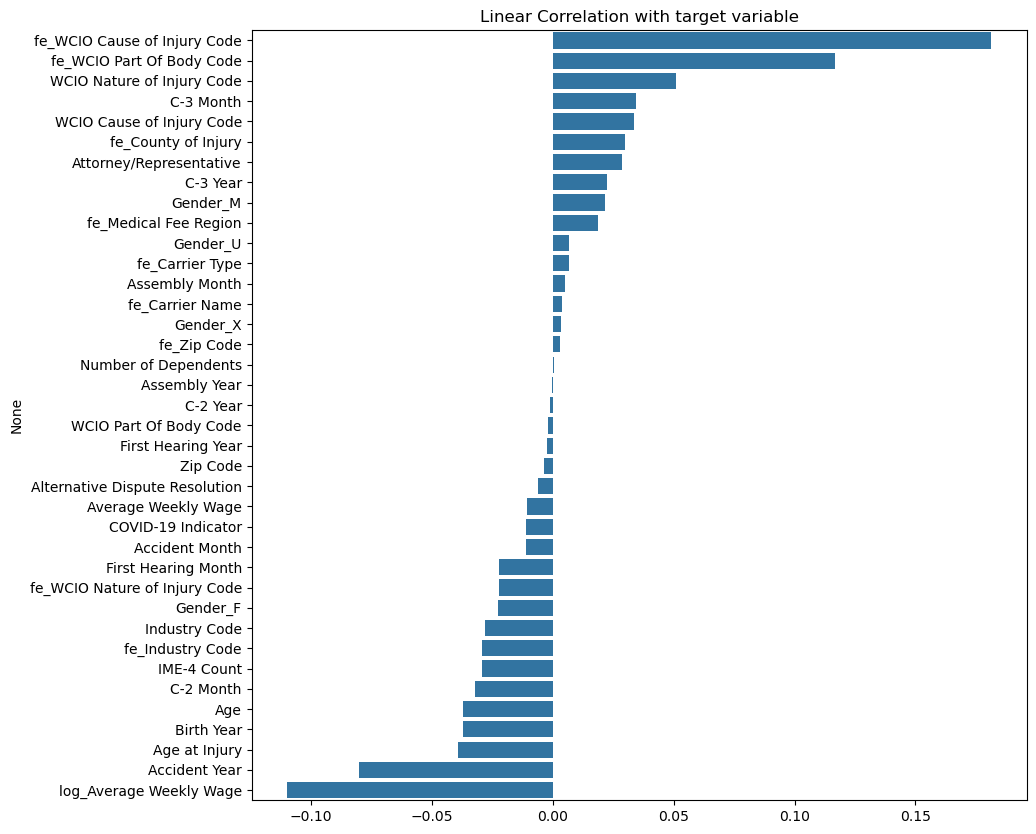

In [11]:
corr_y = df_train[num_features].corrwith(y_train)
corr_y = corr_y.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=corr_y.values, y=corr_y.index)
plt.title('Linear Correlation with target variable')

plt.show()

#### entropy correlation

In [ ]:
s_corr_y = []
for col in num_features:
    s_col = leo.two_col_entropy_corr(df_train[col], y_train)
    s_col = log((s_col +1)/2)
    s_corr_y.append(s_col)
    
s_corr_y = pd.Series(s_corr_y, index=num_features).sort_values(ascending=False)
s_corr_y = s_corr_y.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=s_corr_y.values, y=s_corr_y.index)
plt.title('Entropy Correlation with target variable')
plt.show()  

#### chi2 correlation for categorical features

In [ ]:
from scipy.stats import chi2_contingency

In [ ]:
def sigmoid(x, a=20):
    return 1 / (1 + np.exp(-a * (x - 0.5)))

plt.figure(figsize=(12, 8))
x = np.linspace(0, 1, 100)
y = sigmoid(x)
plt.plot(x, y)
plt.title('Sigmoid Function')
plt.xlabel('x')

In [ ]:
def chi2_feature_importance(f1, target, significance_level=0.05, log=False):
    """
    Evaluate if a feature is important to predict the target using the Chi-squared test.

    Parameters:
        data (pd.DataFrame): The dataset containing the feature and target.
        feature (str): The name of the feature column.
        target (str): The name of the target column.
        significance_level (float): The threshold for statistical significance (default 0.05).

    Returns:
        dict: A dictionary containing the chi-squared statistic, p-value, and whether the feature is important.
    """
    # Create a contingency table
    contingency_table = pd.crosstab(f1, target)

    # Perform the Chi-squared test
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

    total_observations = contingency_table.sum().sum()
    rows, cols = contingency_table.shape

    cramers_v = np.sqrt(
        chi2_stat / (total_observations * min(cols - 1, rows - 1)))

    is_important = p_value < significance_level

    if log:
        if cramers_v < 0.3:
            print(f" {is_important} the test is not significant {cramers_v}")
        elif cramers_v < 0.5:
            print(f" {is_important} the test is weakly significant {cramers_v}")
        elif cramers_v < 0.7:
            print(f" {is_important} the test is moderately significant {cramers_v}")
        elif cramers_v < 1:
            print(f" {is_important} the test is highly significant {cramers_v}")
        else:
            print(f"the test has no sense {cramers_v}")

    # Determine if the feature is important
    is_important = p_value < significance_level
    return cramers_v, p_value

In [ ]:
df_train[col]

In [ ]:
normalized_scores = []
 
for col in obj_features:
    print(f"Feature: {col}")
    cramers_v, p_value = chi2_feature_importance(df_train[col], y_train, log=True)
    normalized_scores.append((1 - p_value)*sigmoid(cramers_v))
    print(f'normalized score: {normalized_scores[-1]}')
    print("-"*50)

plt.figure(figsize=(10, 10))
sns.barplot(x=normalized_scores, y=obj_features)
plt.title('Normalized Chi-squared Feature Importance')
plt.show()

#### best features level 1

In [ ]:
best_lin = list((corr_y [corr_y.abs() > 0.2]).index)
best_ent = list((s_corr_y [s_corr_y > - 0.5]).index)
best_chi2 = list((pd.Series(normalized_scores, index=obj_features)[pd.Series(normalized_scores, index=obj_features) > 0.5]).index)

In [ ]:
bestnum = set(best_lin + best_ent)
bestnum = list(bestnum)
bestnum.append('fe_Carrier Name')
bestnum

In [ ]:
best_chi2

### correlation between features

#### Linear correlation

In [ ]:
# correlation between numerical features
corr = df_train[bestnum].corr()
#half of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(np.abs(corr), annot=True, cmap='Blues', mask=mask)
plt.title('Correlation Matrix')
plt.show()


#### entropy correlation

In [ ]:
s_corr = leo.entropy_corr(df_train[bestnum])
#half of the matrix
mask = np.zeros_like(s_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(s_corr, annot=True, cmap='Blues', mask=mask)
plt.title('Correlation Matrix')
plt.show()

#### best featues level 2


In [ ]:
bestnum

In [ ]:
bestnum = ['fe_Zip Code',
 'C-3 Month',
 'C-3 Year',
 'fe_WCIO Cause of Injury Code',
 'log_Average Weekly Wage',
 'fe_WCIO Part Of Body Code',
 'Assembly Month',
 'First Hearing Month',
 'fe_Carrier Name']

### RFECV

In [ ]:
#train_test_split for the best features
X_train_big, X_train_small, y_train_big, y_train_small = train_test_split(df_train,
                                                                          y_train,
                                                                          test_size=0.2,
                                                                          random_state=0,
                                                                          stratify=y_train)


#### RFECV random forest for recall

In [ ]:
num_features

In [ ]:

model = RandomForestClassifier(n_estimators=100, random_state=0)
rfe = RFECV(model, cv=3, scoring='recall', n_jobs=-1)

rfe.fit(X_train_big[num_features], y_train_big)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfe.cv_results_['mean_test_score']) + 1), rfe.cv_results_['mean_test_score'])
plt.title('RFECV')
plt.xlabel('Number of Features')
plt.ylabel('Recall')
plt.show()

print(f'Optimal number of features: {rfe.n_features_}')
print(f'Selected features: {df_train[num_features].columns[rfe.support_]}')

### RFE Logistic regression for recall

In [ ]:
model = LogisticRegression(max_iter=1000)
rfe = RFECV(model, cv=3, scoring='recall', n_jobs=-1)

rfe.fit(X_train_big[num_features], y_train_big)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(rfe.cv_results_['mean_test_score']) + 1), rfe.cv_results_['mean_test_score'])
plt.title('RFECV')
plt.xlabel('Number of Features')
plt.ylabel('Recall')
plt.show()


# checkpoint 2

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier  # Import for ANN
# import the naive bayes module
from sklearn.naive_bayes import GaussianNB


## smote and tomek

In [ ]:
df_train_np = df_train[bestnum].to_numpy()
y_train_np = y_train.to_numpy(dtype=int)

In [ ]:

smote_tomek = SMOTETomek(sampling_strategy='auto')

# Ensure y_train contains integer values
y_train_int = y_train.round().astype('float64').to_numpy()
# Assuming you have your feature matrix X and target variable y
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(df_train_np, y_train_np)
df_train_resampled = pd.DataFrame(X_train_resampled, columns=bestnum)
y_train_resampled = pd.Series(y_train_resampled)

#smote = SMOTE(sampling_strategy='minority', random_state=42)

print("Resampling completed successfully!")

In [ ]:
y_train_resampled.value_counts()

In [ ]:
X_resampled_big, X_resampled_small, y_resampled_big, y_resampled_small = train_test_split(df_train_resampled,
                                                                                            y_train_resampled,
                                                                                            test_size=0.2,
                                                                                            random_state=0,
                                                                                            stratify=y_train_resampled)

## multiple model training

### sklearn models

In [ ]:
# make grid search validation for every model in the list model_list_num

model_list_num = [
    SVC(),
    MLPClassifier(),
    GaussianNB(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    HistGradientBoostingClassifier()
]

model_names = ['SVC',
               'MLPClassifier',
               'GaussianNB',
               'LogisticRegression',
               'DecisionTreeClassifier',
               'RandomForestClassifier',
               'HistGradientBoostingClassifier'
]


best_params = []

param_grid_logistc = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

param_grid_tree = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_hgb = {
    'max_iter': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10]
}

param_grid_svc = {
    'C': [0.1, 1, 10],  # Common hyperparameters for SVC
    'kernel': ['linear', 'rbf']  # Try different kernels
}

param_grid_mlp = {  # Hyperparameters for ANN (MLPClassifier)
    'hidden_layer_sizes': [(100,), (100, 50), (100, 100)],  # Different hidden layer configurations
    'activation': ['relu', 'tanh'],  # Experiment with activation functions
    'solver': ['adam', 'lbfgs']  # Choose a suitable solver
}

param_grid_gnb = {  } # GaussianNB has no hyperparameters to tune
param_list = [param_grid_svc,
              param_grid_mlp,
              param_grid_gnb,
              param_grid_logistc,
              param_grid_tree,
              param_grid_rf,
              param_grid_hgb]
best_params = []

tn_list = []
fp_list = []
fn_list = []
tp_list = []

precision_score_list = []

for model, param_grid in zip(model_list_num, param_list):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='precision', n_jobs=-1)
    grid_search.fit(X_resampled_big, y_resampled_big)
    best_params.append(grid_search.best_params_)
    print('-'*50)
    print(model)
    print(f"Best parameters for {model}: {grid_search.best_params_}")
    print(f"Best precision score: {grid_search.best_score_}")
    best_model = model.set_params(**grid_search.best_params_)
    best_model.fit(X_train_resampled, y_train_resampled)
    y_pred = best_model.predict(df_valid[bestnum])
    precision_score_model = precision_score(y_valid, y_pred)
    precision_score_list.append(precision_score_model)
    print(f"Recall: {recall_score(y_valid, y_pred)}")
    print(f"F1: {f1_score(y_valid, y_pred)}")
    print(f"ROC AUC: {roc_auc_score(y_valid, y_pred)}")
    cm = confusion_matrix(y_valid, y_pred)
    print(f"Confusion Matrix: \n{cm}")
    tn, fp, fn, tp = cm.ravel()
    
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    tp_list.append(tp)
    pr = int(precision_score_model * 100)
    
    print(f"{YEQUALS}_pr{pr}_{model_names[model_list_num.index(model)]}_model")
    
    #leo.report_and_save(model = best_model,
    #                   model_name = f"{YEQUALS}_pr{pr}_{model_names[model_list_num.index(model)]}_model",
    #                   y_pred = y_pred,
    #                    y = y_valid,
    #                    feature_list = bestnum
    #                    )   
                        
                        

    
    
    
    
    



### xgboost

In [ ]:
y_train_resampled
y_resampled_big
y_valid

# run a grid search for param_xgb
param_xgb = {
    'max_depth': [3, 5, 7],
    'eta': [0.1, 0.3, 0.5],
    'objective': ['binary:logistic']
}

grid = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_xgb, cv=3, scoring='recall', n_jobs=-1)
grid.fit(X_resampled_big, y_resampled_big)
print(f"Best parameters for XGBoost: {grid.best_params_}")
print(f"Best recall score: {grid.best_score_}")

best_xgb = xgb.XGBClassifier(**grid.best_params_)
best_xgb.fit(X_train_resampled, y_train_resampled)
y_pred = best_xgb.predict(df_valid[bestnum])
print(f"Recall: {recall_score(y_valid, y_pred)}")
print(f"F1: {f1_score(y_valid, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_valid, y_pred)}")

cm = confusion_matrix(y_valid, y_pred)
print(f"Confusion Matrix: \n{cm}")

tn, fp, fn, tp = cm.ravel()
tn_list.append(tn)
fp_list.append(fp)
fn_list.append(fn)
tp_list.append(tp)
pr = precision_score(y_valid, y_pred)
precision_score_list.append(pr)
pr = int(pr * 100)
print(f"{YEQUALS}_pr{pr}_XGBoost_model")
#leo.report_and_save(model = best_xgb,
#                   model_name = f"{YEQUALS}_pr{pr}_XGBoost_model",
#                   y_pred = y_pred,
#                    y = y_valid,
#                    feature_list = bestnum
#                    )
model_names.append('XGBoost')

### lightgbm

In [ ]:
y_train_resampled
y_resampled_big
y_valid

param_lightgbm = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.3, 0.5],
    'objective': ['binary']
}



grid = GridSearchCV(estimator=lightgbm.LGBMClassifier(), param_grid=param_lightgbm, cv=3, scoring='precision', n_jobs=-1)
grid.fit(X_resampled_big, y_resampled_big)
print(f"Best parameters for LightGBM: {grid.best_params_}")
print(f"Best precision score: {grid.best_score_}")

best_lightgbm = lightgbm.LGBMClassifier(**grid.best_params_)
best_lightgbm.fit(X_train_resampled, y_train_resampled)
y_pred = best_lightgbm.predict(df_valid[bestnum])
print(f"Recall: {recall_score(y_valid, y_pred)}")
print(f"F1: {f1_score(y_valid, y_pred)}")
print(f"ROC AUC: {roc_auc_score(y_valid, y_pred)}")

cm = confusion_matrix(y_valid, y_pred)
print(f"Confusion Matrix: \n{cm}")
tn, fp, fn, tp = cm.ravel()
tn_list.append(tn)
fp_list.append(fp)
fn_list.append(fn)
tp_list.append(tp)

pr = precision_score(y_valid, y_pred)
precision_score_list.append(pr)
pr = int(pr * 100)
print(f"{YEQUALS}_pr{pr}_LightGBM_model")

#leo.report_and_save(model = best_lightgbm,
#                   model_name = f"{YEQUALS}_pr{pr}_LightGBM_model",
#                   y_pred = y_pred,
#                   y = y_valid,
#                   feature_list = bestnum
#                   )
model_names.append('LightGBM')

In [ ]:
fig, ax = plt.subplots()
width = 0.3 # width of bar
x = np.arange(len(model_names))
ax.bar(x, tn_list, width, color='b', label='True Negative')
ax.bar(x + width, tp_list, width, color='g', label='True Positive')
# rotate the tick labels for better visibility
ax.set_xticklabels(model_names, rotation = 80)
ax.set_ylabel('Scores')
ax.set_title('Scores by type')

ax.set_xticks(x + width)
ax.set_xticklabels(model_names)
ax.legend()
plt.show()

# checkpoint 3

## recursive feature elimination

# checkpoint 4